In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
import corner
import pymultinest
import json
import getdist
from getdist import plots, MCSamples

Define the same neg log likelihood as in `rosenbrock_function_sampling_mcmc`:

In [2]:
def rosenbrock_neg_log_likelihood(params, a=1, b=100):
    """
    Negative Log-likelihood function given by the negative of the Rosenbrock function
    param params: tuple of (x, y) as the inputs to the rosenbrock function,
    which is:
    
    f(x,y)=(a-x)^{2}+b(y-x^{2})^{2}
    
    where we use a=1, b=100 as default parameters
    """
    x = params[0]
    y = params[1] # params is tuple of 2 numbers
    # Use the rosenbrock function as our log-likelihood
    log_likelihood = ((a - x) ** 2) + (b * (y - x ** 2) ** 2)
    # return the negative log-likelihood
    return -log_likelihood


Test to make sure the function is being plotted:

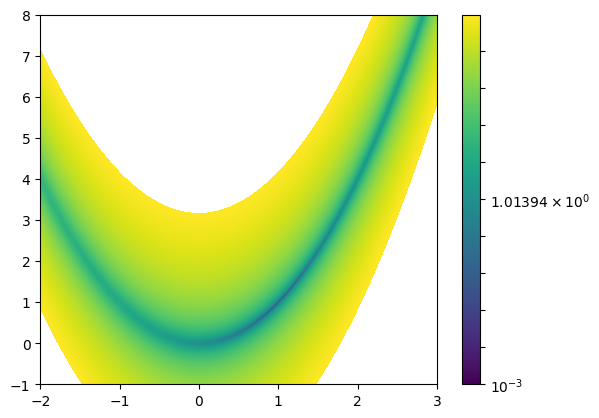

In [3]:
npoints = 500

# bounds of our sampling
x_lower = -2
x_upper = 3
y_lower = -1
y_upper = 8

testarr = np.zeros((npoints, npoints))
X, Y = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints))

for i in range(0, len(X)):
    for j in range(0, len(Y)):
        testarr[i, j] = -rosenbrock_neg_log_likelihood((X[i, j], Y[i, j]))  # negative of neg log likelihood

# plot
plt.contourf(X, Y, testarr, levels=np.logspace(-3, 3, npoints), norm = LogNorm())
plt.colorbar()
plt.show()

Define a uniform prior (as multinest uses prior instead of log-prior):

In [4]:
def rosenbrock_prior(cube, x_min=x_lower, x_max=x_upper, y_min=y_lower, y_max=y_upper):
    """
    Prior that is uniform 1 over x = (-2, 3), y = (-1, 8) and 0 outside of that range
    params are x, y
    
    Transforms uniform unit cube to cube defined by x and y above
    """

    cube[0] = cube[0] * (x_upper - x_lower) + x_lower  # transforms [0, 1] unit cube to [x_lower, x_upper] uniform
    cube[1] = cube[1] * (y_upper - y_lower) + y_lower  # transforms [0, 1] unit cube to [y_lower, y_upper] uniform
    
    return cube

Set up the nested sampler:

In [5]:
params = ['x', 'y']
n_params = len(params)

Run PyMultiNest:

In [6]:
# MultiNest Nested Sampling
result = pymultinest.solve(LogLikelihood=rosenbrock_neg_log_likelihood, Prior=rosenbrock_prior, 
    n_dims=n_params, n_live_points=int(1e4), evidence_tolerance=0.1, verbose=True)

# This might take a few minutes to run
result

  analysing data from /tmp/tmp33gih4e6pymultinest/.txt


{'logZ': -4.9784199977465455,
 'logZerr': 0.019974613682100937,
 'samples': array([[-0.24601024, -0.27530414],
        [-0.50011011,  0.51585938],
        [-1.98075083,  3.95089798],
        ...,
        [ 0.93957133,  0.87431703],
        [ 0.92525539,  0.84534528],
        [ 0.9290597 ,  0.84845217]])}

Plotting $2$-D histogram of the sampled distribution:

Removed no burn in


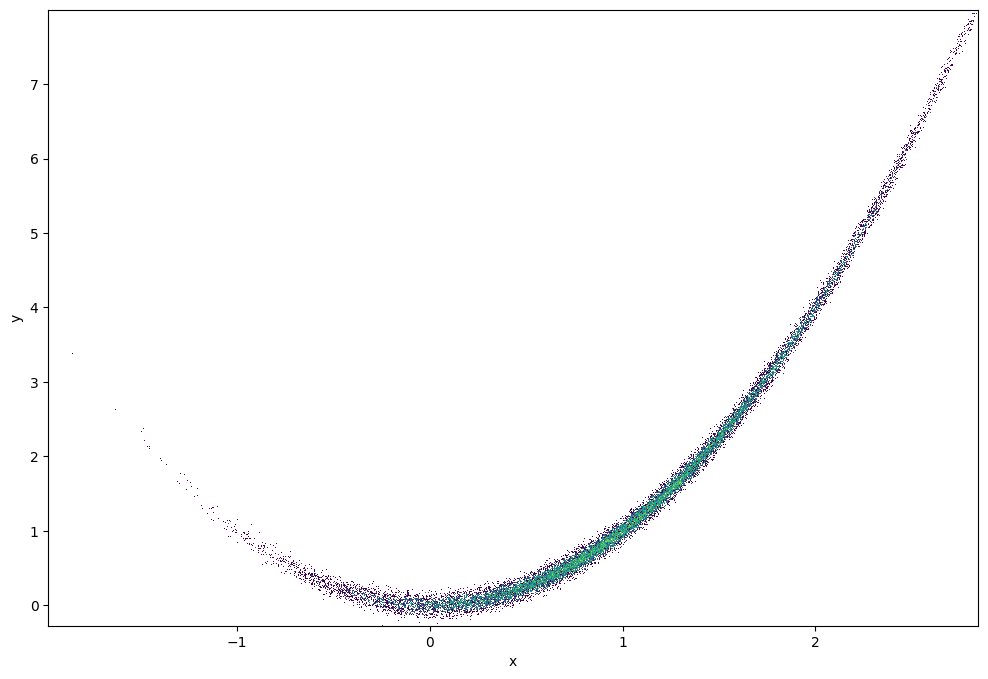

In [7]:
samples = MCSamples(samples=result['samples'], names=['x', 'y'], labels=['x', 'y'])
# g.add_2d_scatter(samples, 'x', 'y',)
plt.figure(figsize = (12, 8))
plt.hist2d(result['samples'][:,0], result['samples'][:,1], norm = LogNorm(), bins=1000)
# g.plot_2d(samples, 'x', 'y', shaded=True)
plt.xlabel('x'), plt.ylabel('y')
plt.show()

and contours:

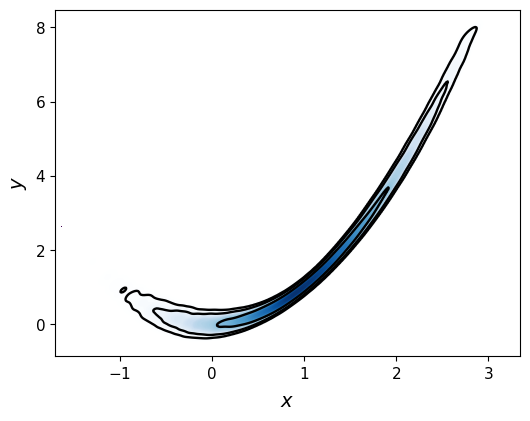

In [8]:
# Filled 2D comparison plot with legend
g = plots.get_single_plotter(width_inch=6)
samples.updateSettings({'contours': [0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 3

# plotting
plt.hist2d(result['samples'][:,0], result['samples'][:,1], norm = LogNorm(), bins=1000)
g.plot_2d(samples, 'x', 'y', shaded=True)
plt.show()